In [1]:
import torch
import gym
import numpy as np
import random
from copy import deepcopy
import PendulumEnv
import time
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
#train on lowest point with zero start velocity
#To test it change in PendulumEnv in reset state on (np.pi, 0)
#Result -206

# Solving Pendulum using CEM

In [3]:
def generate_session(agent, env, t_max=200):
  """
    Generate session on environment with agent
  """
  state = env.reset()
  actions = []
  states = []
  total_reward = 0
  for _ in range(t_max):
    action = agent.get_action(state)
    new_s, r, done, info = env.step(action)
    states.append(state)
    actions.append(action)
    total_reward += r
    state = new_s
    if done:
      break
  return states, actions, total_reward

def select_elites(states, actions, rewards, percentile=50):
  """
    Select sessions with the most reward
    by percentile
  """
  reward_threshold = np.percentile(rewards, percentile)
  elite_states, elite_actions = [], []
  for i in range(len(rewards)):
    if rewards[i] > reward_threshold:
      elite_states.append(states[i])
      elite_actions.append(actions[i])
  return elite_states, elite_actions

def show_progress(log, reward_batch, percentile, epoch):
    mean_reward = np.mean(reward_batch)
    threshold = np.percentile(reward_batch, percentile)
    log.append([mean_reward, threshold])
    clear_output(True)
    print(f'Epoch: {epoch}, mean reward: {mean_reward}, threshold: {threshold}')
    plt.figure(figsize=[8, 4])
    plt.plot(list(zip(*log))[0], label='Mean_rewards')
    plt.plot((list(zip(*log)))[1], label='Threshold')
    plt.legend()
    plt.grid()
    plt.show()

In [4]:
def fanin_init(size, fanin=None):
    fanin = fanin or size[0]
    v = 1. / np.sqrt(fanin)
    return torch.Tensor(size).uniform_(-v, v)

class Network(torch.nn.Module):
  def __init__(self, state_shape):
    super().__init__()
    self.linear_1 = torch.nn.Linear(state_shape[0], 50)
    self.linear_3 = torch.nn.Linear(50, 30)
    self.linear_4 = torch.nn.Linear(30, 1)
    self.relu = torch.nn.ReLU()
    self.tang = torch.nn.Tanh()
    
    def init_weights(self, init_w):
        self.linear_1.weight.data = fanin_init(self.linear_1.weight.data.size())
        self.linear_2.weight.data = fanin_init(self.linear_2.weight.data.size())
        self.linear_3.weight.data.uniform_(-init_w, init_w)

  def forward(self, state):
    predicted = self.relu(self.linear_1(state))
    predicted = self.relu(self.linear_3(predicted))
    predicted = self.tang(self.linear_4(predicted))
    return predicted * 2
    
    

In [5]:
class CEM_agent(torch.nn.Module):
  def __init__(self, state_shape, action_shape, epsilon=0.99, gamma=0.99,
               tau=1e-3, batch_size=32, learning_rate=1e-2, n_batches=8):
    super().__init__()
    self.batch_size = batch_size
    self.epsilon = epsilon
    self.gamma = gamma
    self.tau = tau
    self.batch_size = batch_size
    self.n_batches = n_batches
    self.loss = torch.nn.MSELoss()
    self.network = Network(state_shape)
#     self.optimizer = torch.optim.SGD(self.network.parameters(), lr=learning_rate)
    self.optimizer = torch.optim.Adam(params=self.network.parameters(), lr=learning_rate)

  def get_batch(self, elite_states, elite_actions):
    batch = random.sample(list(zip(elite_states, elite_actions)),
                          min(len(elite_actions), self.batch_size))
    states, actions = map(np.array, zip(*batch))
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.float32)
    return states, actions
  
  def update_weights(self, old_model):
    for new_parameter, old_parameter in zip(self.network.parameters(),
                                            old_model.parameters()):
      new_parameter.data.copy_((1 - self.tau)*new_parameter + \
                                      (self.tau)*old_parameter)
                                    

  def fit(self, elite_states, elite_actions):
    for _ in range(self.n_batches):
      self.optimizer.zero_grad()
      states, actions = self.get_batch(elite_states, elite_actions)
      predicted = self.network(states)
      loss = self.loss(predicted, actions)
      old_model = deepcopy(self.network)
      loss.backward()
      self.optimizer.step()
      self.update_weights(old_model)
    self.gamma = self.gamma*self.epsilon

  def get_action(self, state):
    state = torch.tensor(np.array([state]), dtype=torch.float)
    action = self.network(state).detach().data.numpy()[0]
    noise = np.random.uniform(low=-2, high=2)*self.gamma
    action = action + noise
    return np.clip(action, - 2, + 2)

def train(agent, env):
  log = []
  n_epochs = 100
  n_sessions = 400
  percentile = 70
  for epoch in range(n_epochs):
    if epoch == 80:
      env = gym.make('Pendulum-v0')
    generated_sessions = [generate_session(agent, env) for _ in range(n_sessions)]
    states, actions, rewards = map(np.array, zip(*generated_sessions))
    elite_states, elite_actions = select_elites(states, actions, rewards, percentile)
    agent.fit(elite_states, elite_actions)
    print(f'Epoch: {epoch}, mean reward: {np.mean(rewards)}')
    show_progress(log, rewards, percentile, epoch)
  

Epoch: 99, mean reward: -429.23409196888, threshold: -125.99080575287823


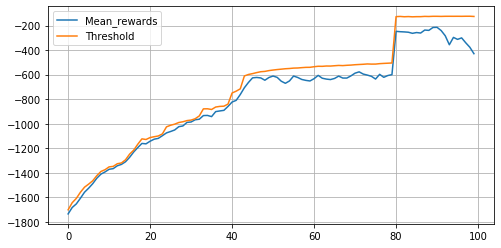

Elapsed time: 67.85204802751541


In [6]:
env = PendulumEnv.PendulumEnv()
action_shape = env.action_space.shape
space_shape = env.observation_space.shape
agent = CEM_agent(space_shape, action_shape)

start = time.time()
train(agent, env)
end = time.time()
print("Elapsed time: {}".format((end-start)/60))

In [7]:
def test_on_real_agent(agent, env, n_sessions=400):
    percentile = 70
    generated_sessions = [generate_session(agent, env) for _ in range(n_sessions)]
    states, actions, rewards = map(np.array, zip(*generated_sessions))
#     agent.fit(elite_states, elite_actions)
    print(f'mean reward: {np.mean(rewards)}')
real_env = gym.make('Pendulum-v0')
test_on_real_agent(agent, real_env, n_sessions=1000)

mean reward: -386.27994072643685
